In [1]:
from fun_opti import *
import time
from PIL import Image as im
from matplotlib import pyplot as plt

# Part I: Optimization of NOV

In [2]:
def remove_needle_centering_v51(img_ori):#(Need Test)
    '''img_ori=Image.open(path_ori)'''
    w_ori,h_ori=img_ori.size

    A=img2bw(ResizeImage(img_ori,w_ori,h_ori))

    left_edge=np.zeros(w_ori)
    right_edge=np.zeros(w_ori)
    for i in range(h_ori):
        for j in range(w_ori):
            if A[i,j-1]>=125 and A[i,j]<125:
                #print('Left position',i,j)
                left_edge[i]=j
            if A[i,j-1]<=125 and A[i,j]>125:
                #print('Right position',i,j)
                right_edge[i]=j

    needle=np.abs(left_edge-right_edge)

    end=0
    for j in range(needle.shape[0]-1):
        j=j+1
        if end == 0:
            if abs((needle[j]-needle[0])/needle[0])>0.05:
                stopline=j
                end=end+1
    #print(stopline)

    addpad=right_edge[stopline]-needle[stopline]/2-w_ori/2

    img_WON=np.zeros((h_ori-stopline,w_ori))
    for i in range(h_ori):
        if i>=stopline:
            img_WON[i-stopline,:]=A[i,:]
    
    h_won,w_won=img_WON.shape
    
    # centering
    if addpad>0:
        img_won=np.hstack( ( img_WON,np.ones((h_won,abs(int(addpad*4))))*255 ) )
    elif addpad<0:
        img_won=np.hstack( ( np.ones((h_won,abs(int(addpad*4))))*255,img_WON ) )
    else:
        img_won=img_WON

    return img_won,needle

## 1.1 Import Expremental Image and Generate Synthetic Image

### Initial syn image

In [ ]:
# FOR DEBUGGING
# Generate the syn image in array.
syn_array,_,_,_=gen_droplet_v5(75,15,rneedle=0.5)


In [ ]:
# FOR DEBUGGING
# crop the white margin of the array
syn_array_cm0=crop_margin_array_v5(syn_array)
# Remove the non-droplet part at the top of the image
syn_array_cm=syn_array_cm0[2:-1]

# Scaling the syn image to a needle diameter of 100 pixel(r=50 pixel)

# The part of the value of 0 is the diameter of the needle
d_pixel=np.sum(syn_array_cm[0]==0)
k_syn=100/d_pixel
syn_zoom=scipy.ndimage.zoom(syn_array_cm,k_syn)

In [3]:
# crop the margin and scaling the syn image to a needle diameter of 100 pixel(r=50 pixel)
def scale_syn(syn_array,output=0):
    # crop the white margin of the array
    syn_array_cm0=crop_margin_array_v5(syn_array)
    # Remove the non-droplet part at the top of the image
    syn_array_cm=syn_array_cm0[2:-1]

    # Scaling the syn image to a needle diameter of 100 pixel(r=50 pixel)

    # The part of the value of 0 is the diameter of the needle
    d_pixel=np.sum(syn_array_cm[0]==0)
    if d_pixel==0:
        d_pixel=1
    k_syn=100/d_pixel
    syn_zoom=scipy.ndimage.zoom(syn_array_cm,k_syn)

    return syn_zoom


### Import and prepost exp image

In [ ]:
# FOR DEBUGGING
# import the exp image
path_ori='./sase_s75.00_v15.00_rn0.50_ln4.00_needle.jpg'
exp_array0,exp_needle=remove_needle_centering_v51(Image.open(path_ori))
exp_array=exp_array0
exp_array[exp_array<125]=0
exp_array[exp_array>=125]=255

# Scaling the syn image to a needle diameter of 100 pixel(r=50 pixel)
k_exp=100/np.sum(exp_array[0]==0)
exp_zoom=scipy.ndimage.zoom(exp_array,k_exp)
# Binarization
exp_zoom[exp_zoom<125]=0
exp_zoom[exp_zoom>=125]=255

plt.imshow(exp_zoom,cmap='gray')

In [4]:
def prepost_exp(path_ori,output=0):
    # import the exp image
    exp_array0,exp_needle=remove_needle_centering_v51(Image.open(path_ori))
    exp_array=exp_array0
    exp_array[exp_array<125]=0
    exp_array[exp_array>=125]=255

    # Scaling the syn image to a needle diameter of 100 pixel(r=50 pixel)
    k_exp=100/np.sum(exp_array[0]==0)
    exp_zoom=scipy.ndimage.zoom(exp_array,k_exp)
    # Binarization
    exp_zoom[exp_zoom<125]=0
    exp_zoom[exp_zoom>=125]=255

    if output!=0:
        plt.imshow(exp_zoom,cmap='gray')
    
    return exp_zoom

## 1.2 Calaculate NOV

In [5]:
def cal_NOV(exp_zoom,syn_zoom,output=0):
    h_exp,w_exp=np.shape(exp_zoom)
    h_syn,w_syn=np.shape(syn_zoom)

    if h_exp<h_syn or w_exp<w_syn:
        NOV=3
        return NOV

    # droplet pixel amount
    droplet=np.sum(exp_zoom==0)

    a0=np.where(exp_zoom[0]==0)[0][0]
    a1=np.where(syn_zoom[0]==0)[0][0]
    x0=a0-a1
    x2=w_exp-x0-w_syn
    y1=h_exp-h_syn
    if x0<0 or x2<0 or y1<0:
        NOV=2
        return NOV

    # syn_arr reshape by add margin
    B1=np.ones((h_syn,x0))*255
    B2=np.ones((h_syn,x2))*255
    B3=np.ones((y1,w_exp))*255
    B_up=np.hstack((B1,syn_zoom,B2))
    B=np.vstack((B_up,B3))

    A=exp_zoom
    A[A==0]=True
    A[A==255]=False

    B[B==0]=True
    B[B==255]=False
    
    C=A+B
    C[C==0]=255
    C[C==2]=255
    C[C==1]=0

    NOV=abs(np.sum(C==0)/droplet)

    # For debugging
    if output!=0:
        return NOV,C
    else:
        return NOV

In [ ]:
#For Debugging
NOV=cal_NOV(exp_zoom=exp_zoom,syn_zoom=syn_zoom)

In [ ]:
# For debugging
h_exp,w_exp=np.shape(exp_zoom)
h_syn,w_syn=np.shape(syn_zoom)

droplet=np.sum(exp_zoom==0)

a0=np.where(exp_zoom[0]==0)[0][0]
a1=np.where(syn_zoom[0]==0)[0][0]
#x0=int(np.sum(exp_zoom[0]==255)/2)
#x0=int((w_exp-w_syn)/2)
x0=abs(a0-a1)

x2=w_exp-x0-w_syn
y1=h_exp-h_syn

B1=np.ones((h_syn,x0))*255
B2=np.ones((h_syn,x2))*255

B3=np.ones((h_exp-h_syn,w_exp))*255

B_up=np.hstack((B1,syn_zoom,B2))
B=np.vstack((B_up,B3))

A=exp_zoom
A[A==0]=True
A[A==255]=False

B[B==0]=True
B[B==255]=False

C=A+B
C[C==0]=255
C[C==2]=255
C[C==1]=0
plt.imshow(C,cmap='gray')

NOV=np.sum(C==0)/droplet

## 1.3 Build the Optimization Function ================

In [18]:
def optimize_NOV(sv,path_ori=os.path.abspath('./sase_s75.00_v15.00_rn0.50_ln4.00_needle.jpg'),output=0,append=1):
    sigma=sv[0]
    v0=sv[1]

    # preprosessing the ori image
    exp_zoom=reshape_Exp(path_ori)

    # gen and post processing the syn image
    syn_array,_,_,_=gen_Drop(sigma=sigma,volume0=v0,rneedle=0.5)
    # syn_arr,wmax,rneedle=gen_doplet_v5(sigma=sigma,volume0=v0,rneedle=0.5)

    # crop the margin of syn image and scale it
    syn_zoom=scale_Syn(syn_array)

    
    if output==0:
        NOV=cal_NOV(exp_zoom=exp_zoom,syn_zoom=syn_zoom,output=output)
        print ('x=%.2f,%.2f and NOV=%.4f'%(sv[0],sv[1],NOV))
        if append==1:
            Xs.append(sv)
            NOVs.append(NOV)  
        return NOV

    else:     
        NOV,C=cal_NOV(exp_zoom=exp_zoom,syn_zoom=syn_zoom,output=output)
        return NOV,C

## 1.4 Start the Optimization

In [7]:
Xs=[]
NOVs=[]

In [14]:
import scipy.optimize
# use scipy obtimaize the parameter
opStart=time.time()
print('Optimization Start')
x0=np.asarray((60,10))
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
res=scipy.optimize.minimize(optimize_NOV,x0,method='nelder-mead',options={'maxiter':15}) #SLSQP #nelder-mead
#res=scipy.optimize.minimize(obtimize_v5,x0,method='SLSQP',options={'maxiter':15})
opEnd=time.time()
print('Optimize Program Running Time: ',opEnd-opStart)

Optimization Start
x=60.00,10.00 and NOV=0.3248
x=63.00,10.00 and NOV=0.3822
x=60.00,10.50 and NOV=0.2387
x=57.00,10.50 and NOV=0.1703
x=54.00,10.75 and NOV=0.0738
x=54.00,11.25 and NOV=0.0419
x=51.00,11.88 and NOV=0.2680
x=48.00,11.50 and NOV=0.2971
x=57.00,10.75 and NOV=0.1383
x=51.00,11.25 and NOV=0.1265
x=52.50,11.12 and NOV=0.0369
x=52.50,11.62 and NOV=0.1550
x=53.62,10.97 and NOV=0.0042
x=52.12,10.84 and NOV=0.0049
x=53.25,10.69 and NOV=0.0345
x=53.06,10.80 and NOV=0.0354
x=52.88,10.91 and NOV=0.0048
x=53.06,11.05 and NOV=0.0166
x=53.44,10.83 and NOV=0.0160
x=53.34,10.88 and NOV=0.0164
x=53.25,10.94 and NOV=0.0193
x=53.34,11.01 and NOV=0.0168
x=53.72,11.04 and NOV=0.0048
x=54.00,11.00 and NOV=0.0068
x=53.84,11.00 and NOV=0.0042
x=53.74,10.93 and NOV=0.0161
x=53.72,11.01 and NOV=0.0170
x=53.73,10.99 and NOV=0.0041
x=53.67,11.00 and NOV=0.0170
x=53.68,10.95 and NOV=0.0046
x=53.68,10.96 and NOV=0.0045
x=53.67,10.99 and NOV=0.0167
x=53.68,10.97 and NOV=0.0042
x=53.68,10.98 and NOV=0.

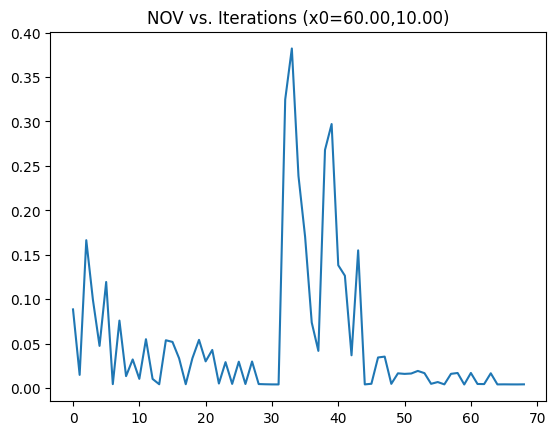

In [15]:
plt.title('NOV vs. Iterations (x0=%.2f,%.2f)'%(x0[0],x0[1]))
plt.plot(NOVs)

In [23]:
NOV,C=optimize_NOV(np.asarray((53.68,10.98)),output=1)

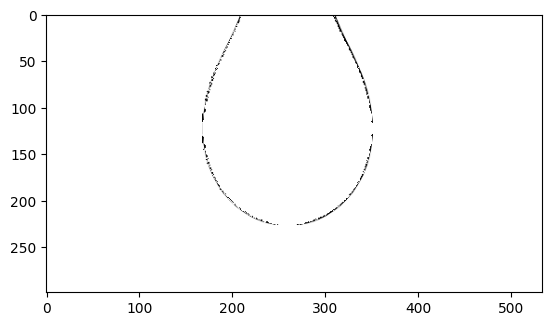

In [24]:
plt.imshow(C,cmap='gray')

# II Part: Calculate the NOVs Map

## NOVs (v=15)

In [44]:
# Calculate the NOVs when v0=15
NOV_v15=[]
for i in np.arange(75,121,1):
    x=np.asarray((i,15))
    NOV15=optimize_NOV(x)
    NOV_v15.append(NOV15)


75
x=75.00,15.00 and NOV=0.0886
76
x=76.00,15.00 and NOV=0.0523
77
x=77.00,15.00 and NOV=0.0292
78
x=78.00,15.00 and NOV=0.0081
79
x=79.00,15.00 and NOV=0.0133
80
x=80.00,15.00 and NOV=0.0282
81
x=81.00,15.00 and NOV=0.0463
82
x=82.00,15.00 and NOV=0.0652
83
x=83.00,15.00 and NOV=0.0788
84
x=84.00,15.00 and NOV=0.0987
85
x=85.00,15.00 and NOV=0.1229
86
x=86.00,15.00 and NOV=0.1496
87
x=87.00,15.00 and NOV=0.1646
88
x=88.00,15.00 and NOV=0.1757
89
x=89.00,15.00 and NOV=0.1939
90
x=90.00,15.00 and NOV=0.2056
91
x=91.00,15.00 and NOV=0.2201
92
x=92.00,15.00 and NOV=0.2333
93
x=93.00,15.00 and NOV=0.2451
94
x=94.00,15.00 and NOV=0.2555
95
x=95.00,15.00 and NOV=0.2688
96
x=96.00,15.00 and NOV=0.2824
97
x=97.00,15.00 and NOV=0.2937
98
x=98.00,15.00 and NOV=0.2937
99
x=99.00,15.00 and NOV=0.3040
100
x=100.00,15.00 and NOV=0.3163
101
x=101.00,15.00 and NOV=0.3265
102
x=102.00,15.00 and NOV=0.3393
103
x=103.00,15.00 and NOV=0.3470
104
x=104.00,15.00 and NOV=0.3582
105
x=105.00,15.00 and NOV=0.3

In [50]:
NOV_v15_0=[]
for i in np.arange(65,75,1):
    x=np.asarray((i,15))
    NOV15=optimize_NOV(x)
    NOV_v15_0.append(NOV15)

65
x=65.00,15.00 and NOV=0.3897
66
x=66.00,15.00 and NOV=0.3124
67
x=67.00,15.00 and NOV=0.2773
68
x=68.00,15.00 and NOV=0.2477
69
x=69.00,15.00 and NOV=0.2548
70
x=70.00,15.00 and NOV=0.2306
71
x=71.00,15.00 and NOV=0.2004
72
x=72.00,15.00 and NOV=0.1716
73
x=73.00,15.00 and NOV=0.1470
74
x=74.00,15.00 and NOV=0.1280


In [51]:
NOV_v15_all=np.hstack([NOV_v15_0,NOV_v15])

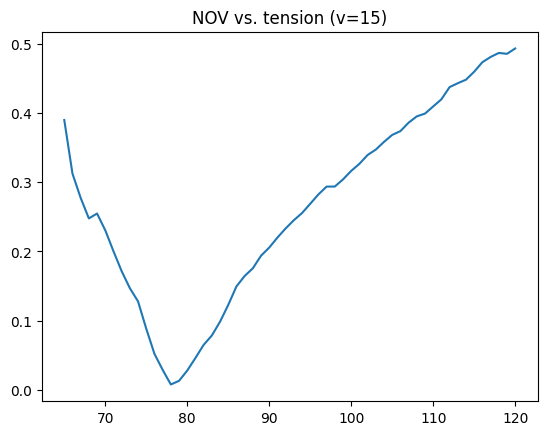

In [52]:
plt.title('NOV vs. tension (v=15)')
plt.plot(np.arange(65,121,1),NOV_v15_all)

## NOVs Contour map

In [8]:
import numpy as np

In [3]:
NOVs_map=np.load('./NOVs_map.npy')

In [19]:
NOVs_exp_map=np.ones((100,30))

In [21]:
for i in np.arange(40,100,1):
    for j in np.arange(10,25,1):
        x=np.asarray((i,j))
        NOV_map=optimize_NOV(x,append=0)
        NOVs_exp_map[i,j]=NOV_map       

x=40.00,10.00 and NOV=3.0000
x=40.00,11.00 and NOV=3.0000
x=40.00,12.00 and NOV=3.0000
x=40.00,13.00 and NOV=3.0000
x=40.00,14.00 and NOV=3.0000
x=40.00,15.00 and NOV=3.0000
x=40.00,16.00 and NOV=3.0000
x=40.00,17.00 and NOV=3.0000
x=40.00,18.00 and NOV=3.0000
x=40.00,19.00 and NOV=3.0000
x=40.00,20.00 and NOV=0.4964
x=40.00,21.00 and NOV=3.0000
x=40.00,22.00 and NOV=3.0000
x=40.00,23.00 and NOV=3.0000
x=40.00,24.00 and NOV=3.0000
x=41.00,10.00 and NOV=0.7912
x=41.00,11.00 and NOV=3.0000
x=41.00,12.00 and NOV=3.0000
x=41.00,13.00 and NOV=3.0000
x=41.00,14.00 and NOV=3.0000
x=41.00,15.00 and NOV=3.0000
x=41.00,16.00 and NOV=3.0000
x=41.00,17.00 and NOV=3.0000
x=41.00,18.00 and NOV=3.0000
x=41.00,19.00 and NOV=3.0000
x=41.00,20.00 and NOV=3.0000
x=41.00,21.00 and NOV=3.0000
x=41.00,22.00 and NOV=3.0000
x=41.00,23.00 and NOV=3.0000
x=41.00,24.00 and NOV=3.0000
x=42.00,10.00 and NOV=0.8140
x=42.00,11.00 and NOV=3.0000
x=42.00,12.00 and NOV=3.0000
x=42.00,13.00 and NOV=1.0839
x=42.00,14.00 

In [22]:
#save the NOV map
np.save('./NOVs_syn_s75_v15_map.npy',NOVs_exp_map)


In [2]:
NOVs_map=np.load('./NOVs_syn_s75_v15_map.npy')

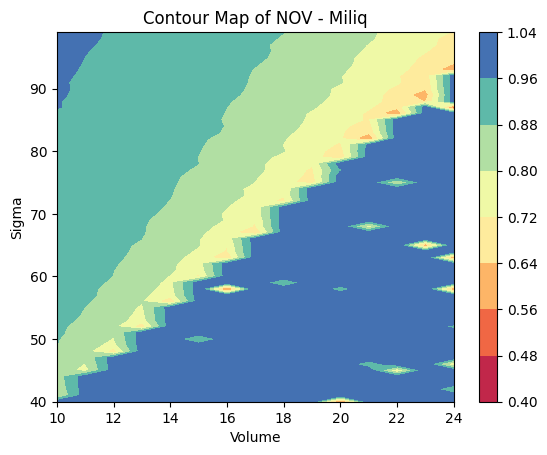

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm
#进行绘图

sigma=np.arange(0,100,1)
volume=np.arange(0,30,1)

fig, ax = plt.subplots()
NOVs_map0=NOVs_map
NOVs_map0[NOVs_map0>1]=1

cs = ax.contourf( volume,sigma, NOVs_map0, cmap=plt.get_cmap('Spectral'))
#im = ax.scatter(y,x,marker='.')


#n=np.arange(y.shape[0])
#for i,txt in enumerate(n):
#    ax.annotate(txt,(y[i],x[i]))
##添加colorbar
cbar = fig.colorbar(cs)

plt.xlabel('Volume')
plt.ylabel('Sigma')

plt.xlim((10,24))
plt.ylim((40,99))
plt.title(('Contour Map of NOV - Miliq'))
plt.show()

In [82]:
#save the NOV map
np.save('./NOVs_map.npy',NOVs_map)


In [102]:
import scipy.optimize
# initialize the Xs and NOVs
Xs=[]
NOVs=[]
# use scipy obtimaize the parameter
opStart=time.time()
print('Optimization Start')
x0=np.asarray((75,15))
#sigma; v0; length_Ne,r_Ne; x,y; scaling_rate;
res=scipy.optimize.minimize(optimize_NOV,x0,method='nelder-mead',options={'maxiter':15}) #SLSQP #nelder-mead
#res=scipy.optimize.minimize(obtimize_v5,x0,method='SLSQP',options={'maxiter':15})
opEnd=time.time()
print('Optimize Program Running Time: ',opEnd-opStart)

Optimization Start
x=75.00,15.00 and NOV=0.0886
x=78.75,15.00 and NOV=0.0149
x=75.00,15.75 and NOV=0.1664
x=78.75,14.25 and NOV=0.0994
x=77.81,14.62 and NOV=0.0475
x=81.56,14.62 and NOV=0.1194
x=76.64,14.91 and NOV=0.0045
x=77.58,15.28 and NOV=0.0759
x=77.75,14.79 and NOV=0.0135
x=75.64,14.70 and NOV=0.0322
x=77.97,14.92 and NOV=0.0104
x=76.86,15.04 and NOV=0.0550
x=77.53,14.85 and NOV=0.0103
x=76.20,14.83 and NOV=0.0043
x=75.31,14.79 and NOV=0.0538
x=75.31,14.89 and NOV=0.0520
x=76.97,14.86 and NOV=0.0335
x=76.42,14.87 and NOV=0.0044
x=76.86,14.84 and NOV=0.0335
x=75.75,14.86 and NOV=0.0543
x=76.59,14.85 and NOV=0.0301
x=76.03,14.86 and NOV=0.0429
x=76.45,14.85 and NOV=0.0051
x=76.17,14.85 and NOV=0.0292
x=76.38,14.85 and NOV=0.0047
x=76.24,14.85 and NOV=0.0297
x=76.34,14.85 and NOV=0.0046
x=76.27,14.85 and NOV=0.0299
x=76.33,14.85 and NOV=0.0045
x=76.29,14.85 and NOV=0.0043
x=76.07,14.82 and NOV=0.0042
x=75.89,14.79 and NOV=0.0041
Optimize Program Running Time:  80.49950098991394


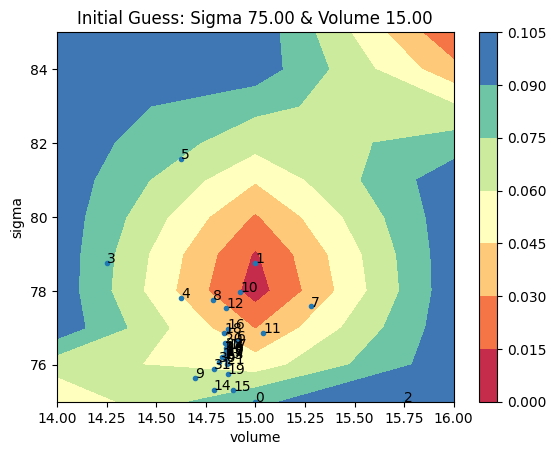

In [96]:
# Import the Map Data
NOVs_map=np.load('./NOVs_map.npy')
sigma=np.arange(0,100,1)
volume=np.arange(0,20,1)


arxs=np.asarray(Xs)
x=arxs[:,0]
y=arxs[:,1]
z=NOVs

fig, ax = plt.subplots()
cs = ax.contourf(volume, sigma, NOVs_map, cmap=plt.get_cmap('Spectral'))
im = ax.scatter(y,x,marker='.')


n=np.arange(y.shape[0])
for i,txt in enumerate(n):
    ax.annotate(txt,(y[i],x[i]))
#添加colorbar
cbar = fig.colorbar(cs)

plt.xlabel('volume')
plt.ylabel('sigma')

plt.xlim((14,16))
plt.ylim((75,85))

plt.title('Initial Guess: Sigma %.2f & Volume %.2f'%(x0[0], x0[1]))

plt.show()

### Calculate Local Map

In [17]:
# Calculate local map
s1=52.5; s2=55; v1=10.6; v2=11.4; step=0.1
NOVs_localmap=np.ones((int(s2*10),int(v2*10))) #sigma,volume

In [27]:
# Calculate local map
for i in np.arange(720,760,0.1):
    for j in np.arange(140,150,0.1):
        print (i/10,j/10)
        x=np.asarray((i/10,j/10))
        NOVs_localmap[i,j]=optimize_NOV(x,append=0)   

72.0 14.0
x=72.00,14.00 and NOV=0.0151


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [100]:
#save the NOV map
np.save('./NOVs_localmap_s_%.2f-%.2f_v_%.2f-%.2f_step_%.0f.npy'%(s1,s2,v1,v2,step),NOVs_localmap)


In [123]:
label=np.asarray(NOVs)[0:20]

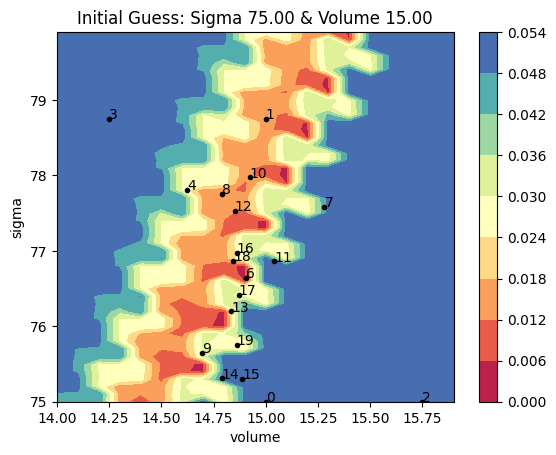

In [128]:
# Import the Map Data
NOVs_localmap=np.load('./NOVs_localmap_s75v15.npy')
sigma=np.arange(0,80,0.1)
volume=np.arange(0,16,0.1)
NOVs_localmap0=NOVs_localmap
NOVs_localmap0[NOVs_localmap0>0.05]=0.05

arxs=np.asarray(Xs)
x=arxs[:,0][0:20]
y=arxs[:,1][0:20]
label=np.asarray(NOVs)[0:20]
z=NOVs

fig, ax = plt.subplots()
cs = ax.contourf(volume, sigma, NOVs_localmap, cmap=plt.get_cmap('Spectral'))
im = ax.scatter(y,x,marker='.',c='black')


n=np.arange(y.shape[0])
for i,txt in enumerate(n):
    ax.annotate(txt,(y[i],x[i]))
#添加colorbar
cbar = fig.colorbar(cs)

#for i in range(len(x)):
#    plt.text(x[i],y[i],label[i])

plt.xlabel('volume')
plt.ylabel('sigma')

plt.xlim((14,15.9))
plt.ylim((75,79.9))

plt.title('Initial Guess: Sigma %.2f & Volume %.2f'%(x0[0], x0[1]))

plt.show()